In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
np.random.seed(7)
%matplotlib inline

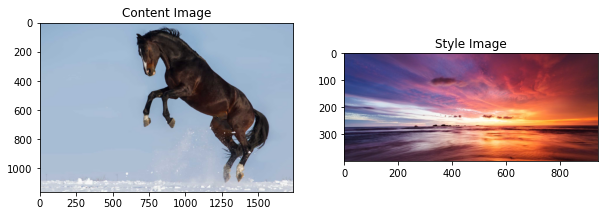

In [2]:
content_img = plt.imread('Horse.jpg')
style_img = plt.imread('Sunset.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(content_img)
ax1.set_title('Content Image')
ax2.imshow(style_img)
ax2.set_title('Style Image')
plt.show()

In [3]:
def image2array(img):
    """
    """
    img = plt.imread(img)
    img = tf.image.convert_image_dtype(image=img, dtype=tf.float32)
    img = tf.image.resize(img, [300, 400])
    img = tf.expand_dims(img, axis=0)
    
    return img

In [4]:
content_tensor = image2array('Horse.jpg')
style_tensor = image2array('Sunset.jpg')

In [17]:
plt.imshow(tf.reshape(content_tensor, [200, 150, 3]))

InvalidArgumentError: Input to reshape is a tensor with 360000 values, but the requested shape has 90000 [Op:Reshape]

In [ ]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
    print(layer.name)

In [ ]:
content_layers = ['block4_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

In [ ]:
def get_model(layers_name, model):
    """
    """
    
    outputs = [model.get_layer(layer).output for layer in layers_name]
    
    model = Model(model.input, outputs)
    
    return model

In [ ]:
def gram_matrix(tensor):
    """
    """
    temp = tensor
    temp = tf.squeeze(temp)
    matmul = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(matmul, axis=0)
    
    return gram

In [ ]:
class CustomModel(tf.keras.Model):
    
    def __init__(self, content_layers, style_layers):
        super(CustomModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        num_style_layers = len(style_layers)
        self.vgg = get_model(style_layers + content_layers, vgg)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # Rescaling back to original size
        inputs = inputs * 255.
        # Normalizing with respect to VGG19 data
        preprocessed_inputs = preprocess_input(inputs)
        # Feeding inputs to our get_model to get outputs of the selected layers.
        outputs = self.vgg(preprocessed_inputs)
        
        style_outputs = outputs[:num_style_layers]
        content_outputs = outputs[num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        style_dict = {style_name:value
                     for style_name, value in
                     zip(self.style_layers, style_outputs)}
        content_dict = {content_name:value for
                       content_name, value in
                       zip(content_layers, content_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = CustomModel(content_layers, style_layers)
style_targets = extractor(style_tensor)['style']
content_targets = extractor(content_tensor)['content']

In [18]:
ct = tf.Variable(content_targets['block4_conv2'])

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [20]:
style_weight = 80
content_weight = 12

style_weights = {
    'block1_conv1':1.0,
    'block2_conv1':0.9,
    'block3_conv1':0.7,
    'block4_conv1':0.5,
    'block5_conv1':0.3
}

In [21]:
def total_loss(outputs):
    """
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                          for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    return content_loss + style_loss

In [22]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        
        outputs = extractor(image)
        
        loss = total_loss(outputs)
        
        grads = tape.gradient(loss, image)
        
        optimizer.apply_gradients([(grads, image)])
        
        image.assign(tf.clip_by_value(image, clip_value_max=1.0, clip_value_min=0.0))

In [23]:
target_image = tf.Variable(content_tensor)

In [ ]:
epochs = 10
steps_per_epoch = 60

step = 0
for i in range(epochs):
    for j in range(steps_per_epoch):
        step += 1
        train_step(target_image)
    print(target_image.shape)
    plt.imshow(np.squeeze(target_image.read_value(), 0))
    print("Train Step: {}".format(step))
    plt.show()